In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras_spiking

tf.random.set_seed(0)
np.random.seed(0)

In [2]:
# Load MNIST Digits Dataset
((train_images, train_labels),(test_images, test_labels),) = tf.keras.datasets.mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]

num_classes = len(class_names)
    
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

def train(input_model, train_x, test_x):
    input_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    input_model.fit(train_x, train_labels, epochs=10)

    _, test_acc = input_model.evaluate(test_x, test_labels, verbose=2)


    print("\nTest accuracy:", test_acc)
    
def check_output(seq_model, modify_dt=None):
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model with the functional API, so that we can
    # access the output of intermediate layers
    inp = x = tf.keras.Input(batch_shape=seq_model.layers[0].input_shape)

    has_global_average_pooling = False
    for layer in seq_model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            # remove the pooling so that we can see the model's
            # output over time
            has_global_average_pooling = True
            continue

        if isinstance(layer, (keras_spiking.SpikingActivation, keras_spiking.Lowpass)):
            cfg = layer.get_config()
            # update dt, if specified
            if modify_dt is not None:
                cfg["dt"] = modify_dt
            # always return the full time series so we can visualize it
            cfg["return_sequences"] = True

            layer = type(layer)(**cfg)

        if isinstance(layer, keras_spiking.SpikingActivation):
            # save this layer so we can access it later
            spike_layer = layer

        x = layer(x)

    func_model = tf.keras.Model(inp, [x, spike_layer.output])

    # copy weights to new model
    func_model.set_weights(seq_model.get_weights())

    # run model
    output, spikes = func_model.predict(test_sequences)

    if has_global_average_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from only the last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * spike_layer.dt
    n_spikes = spikes * spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_names[test_labels[ii]])
        plt.imshow(test_images[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_sequences.shape[1]) * spike_layer.dt,
            tf.nn.softmax(output[ii]),
        )
        plt.legend(class_names, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()
    return (100 * accuracy)

In [14]:
keras_spiking.default.dt = 0.01
time_step = 0.01

In [15]:
tau_acc_dict = dict()

No lowpass
Epoch 1/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4360 - accuracy: 0.8763
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1194 - accuracy: 0.9654
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0851 - accuracy: 0.97470s - loss: 0.0851 - accu
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0597 - accuracy: 0.9816
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0408 - accuracy: 0.9879
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0329 - accuracy: 0.9908
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0253 - accuracy: 0.9926
Epoch 8/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0221 - accuracy: 0.99330s - loss: 0.0221 
Epoch 9/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0177 - accuracy: 0.9946
Epoch 10/10

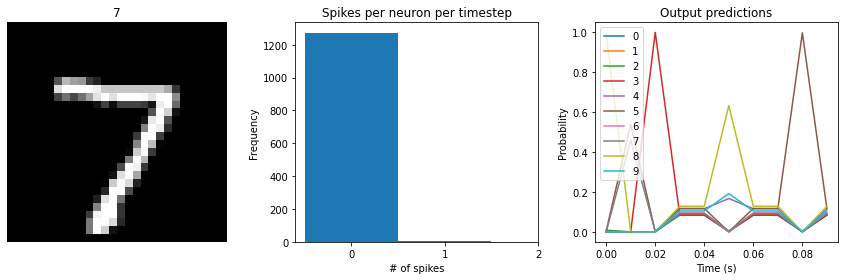

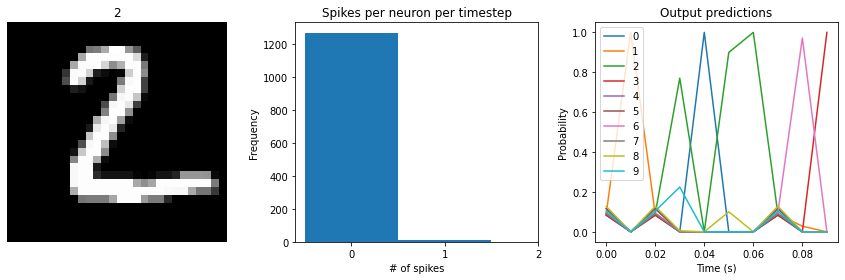

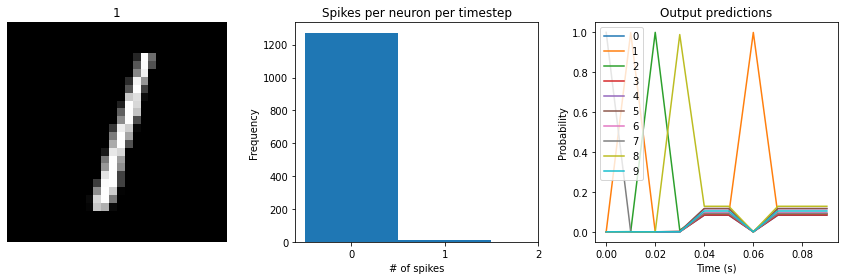

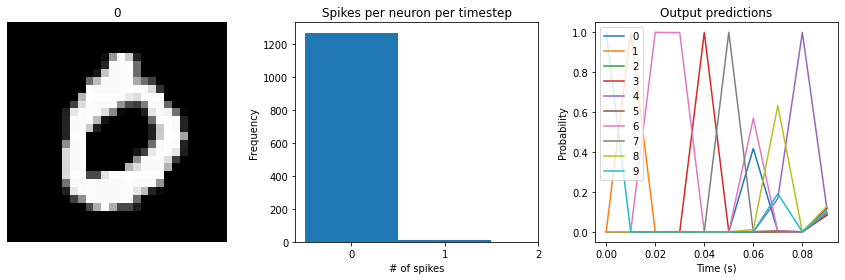

In [16]:
print("No lowpass")
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)

Tau: 0.005
Epoch 1/10
1875/1875 [==============================] - 66s 34ms/step - loss: 0.4231 - accuracy: 0.8806
Epoch 2/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.1147 - accuracy: 0.9666
Epoch 3/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0802 - accuracy: 0.9758
Epoch 4/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0582 - accuracy: 0.9828
Epoch 5/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0398 - accuracy: 0.9882
Epoch 6/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0333 - accuracy: 0.9903
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0248 - accuracy: 0.9926
Epoch 8/10
1875/1875 [==============================] - 52s 27ms/step - loss: 0.0219 - accuracy: 0.9936
Epoch 9/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0180 - accuracy: 0.9944
Epoch 10/10
1875/1875 [==============================

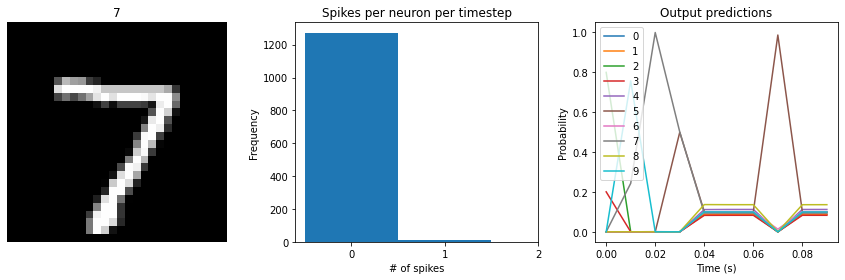

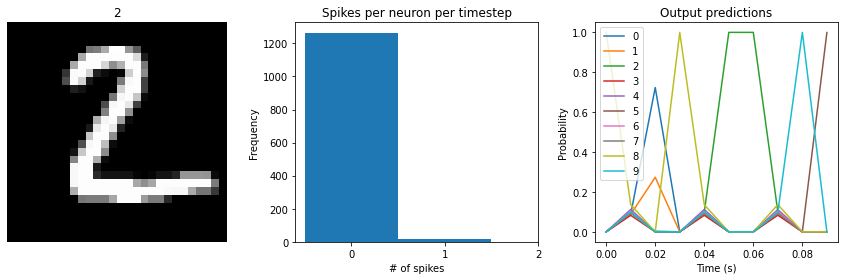

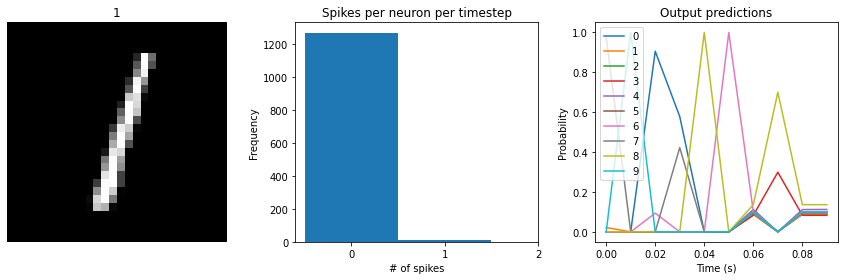

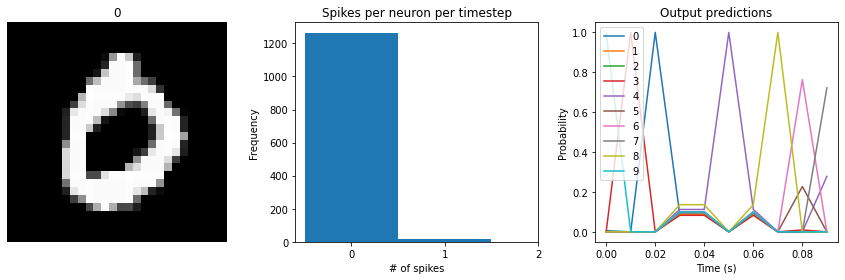

In [24]:
tau = 0.005
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.01
Epoch 1/10
1875/1875 [==============================] - 58s 30ms/step - loss: 0.4458 - accuracy: 0.8764
Epoch 2/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1138 - accuracy: 0.9670
Epoch 3/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0805 - accuracy: 0.9765
Epoch 4/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0576 - accuracy: 0.9828
Epoch 5/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0397 - accuracy: 0.9883
Epoch 6/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0327 - accuracy: 0.9901
Epoch 7/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0246 - accuracy: 0.9927
Epoch 8/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0210 - accuracy: 0.9941
Epoch 9/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0191 - accuracy: 0.9939
Epoch 10/10
1875/1875 [==============================]

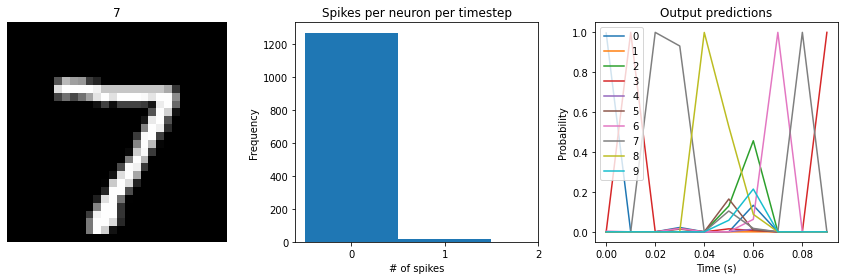

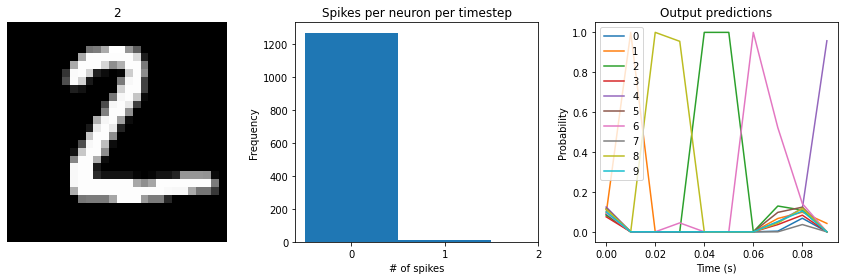

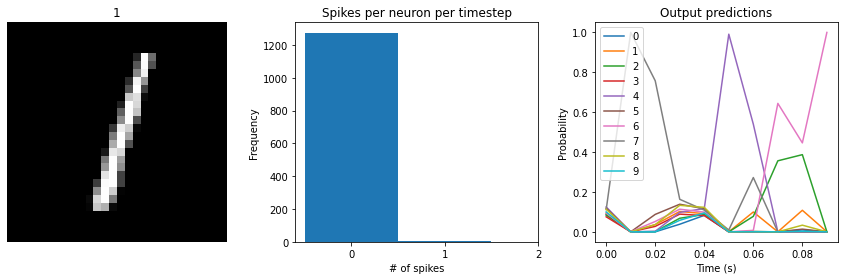

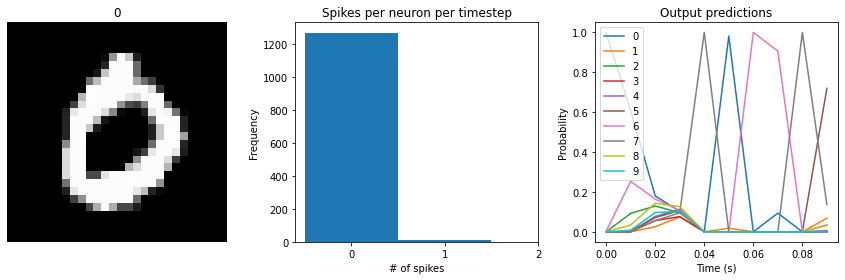

In [18]:
tau = 0.01
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.05
Epoch 1/10
1875/1875 [==============================] - 58s 30ms/step - loss: 0.4443 - accuracy: 0.8788
Epoch 2/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.1163 - accuracy: 0.9653
Epoch 3/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0815 - accuracy: 0.9756
Epoch 4/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0577 - accuracy: 0.9824
Epoch 5/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0414 - accuracy: 0.9869
Epoch 6/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0320 - accuracy: 0.9907
Epoch 7/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0255 - accuracy: 0.9924
Epoch 8/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0216 - accuracy: 0.99380s - loss: 0.021
Epoch 9/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0182 - accuracy: 0.9946
Epoch 10/10
1875/1875 [===============

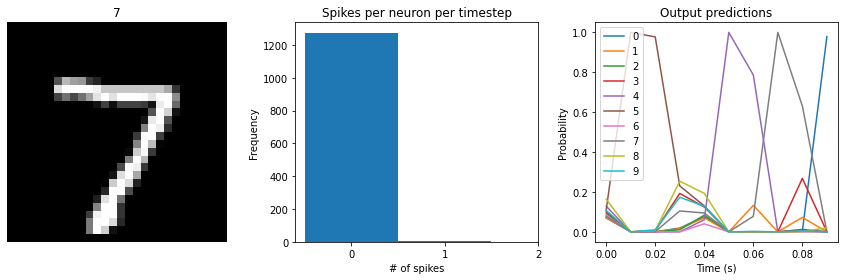

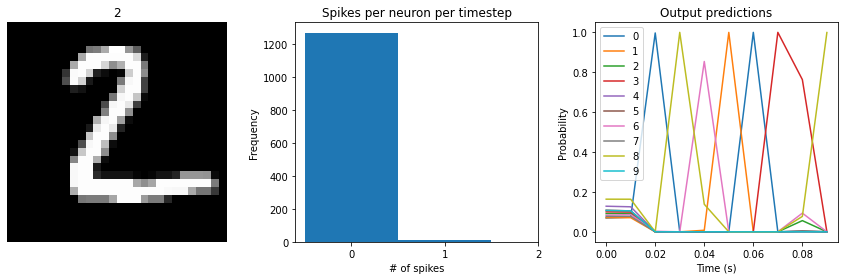

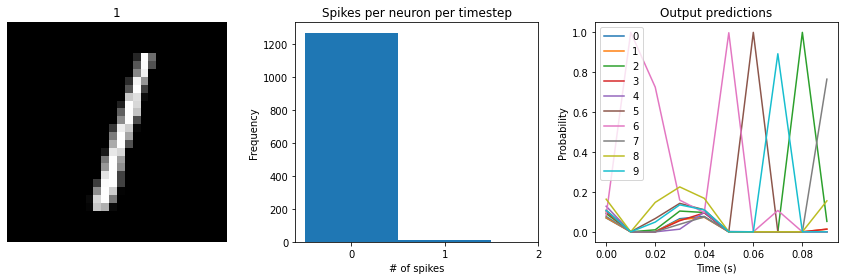

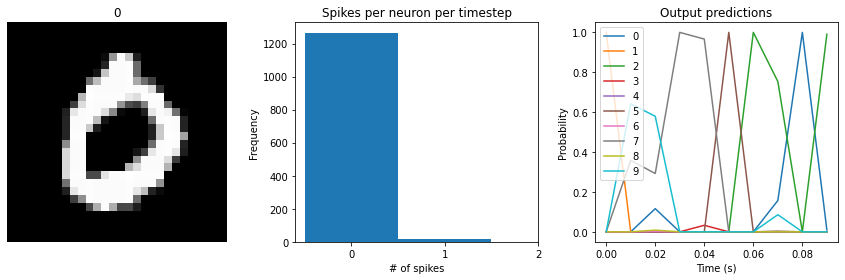

In [19]:
tau = 0.05
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.1
Epoch 1/10
1875/1875 [==============================] - 58s 30ms/step - loss: 0.4344 - accuracy: 0.8825
Epoch 2/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1134 - accuracy: 0.9665
Epoch 3/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0805 - accuracy: 0.9754
Epoch 4/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0585 - accuracy: 0.9821
Epoch 5/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0405 - accuracy: 0.9876
Epoch 6/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0334 - accuracy: 0.9899
Epoch 7/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0255 - accuracy: 0.9923
Epoch 8/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0217 - accuracy: 0.9935
Epoch 9/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0190 - accuracy: 0.9944
Epoch 10/10
1875/1875 [==============================] 

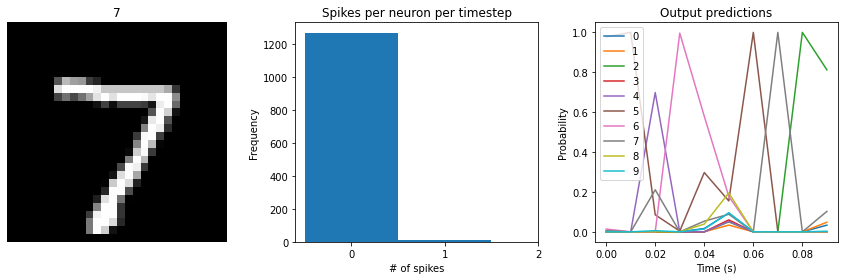

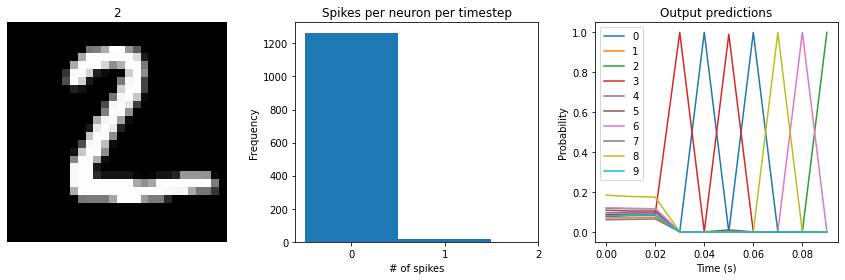

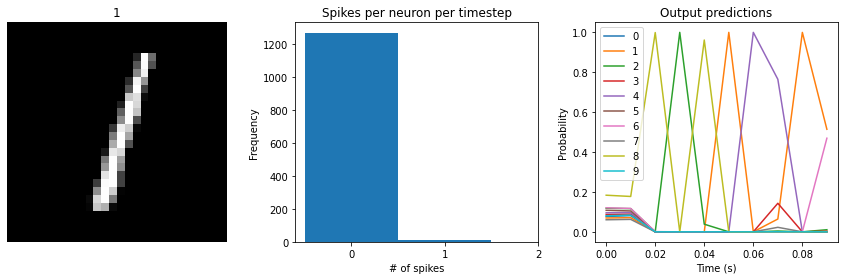

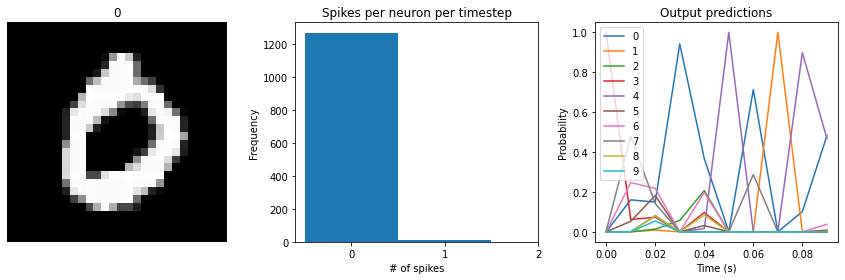

In [20]:
tau = 0.1
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.5
Epoch 1/10
1875/1875 [==============================] - 58s 29ms/step - loss: 0.4475 - accuracy: 0.8752
Epoch 2/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1154 - accuracy: 0.9667
Epoch 3/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0815 - accuracy: 0.9755
Epoch 4/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0586 - accuracy: 0.9821
Epoch 5/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0407 - accuracy: 0.9878
Epoch 6/10
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0341 - accuracy: 0.98960s - loss: 0.0341 - accuracy: 0.
Epoch 7/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0259 - accuracy: 0.9924
Epoch 8/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0222 - accuracy: 0.9932
Epoch 9/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0173 - accuracy: 0.9948
Epoch 10/10
1875/1875 [

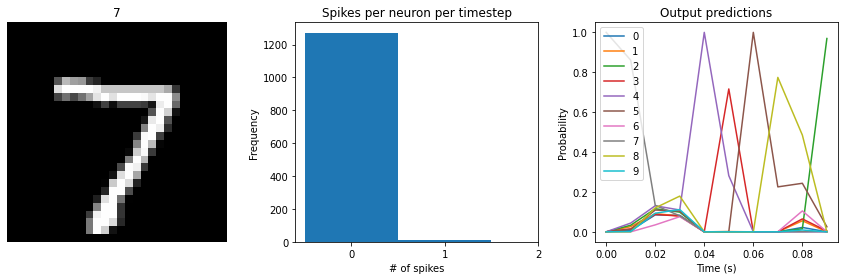

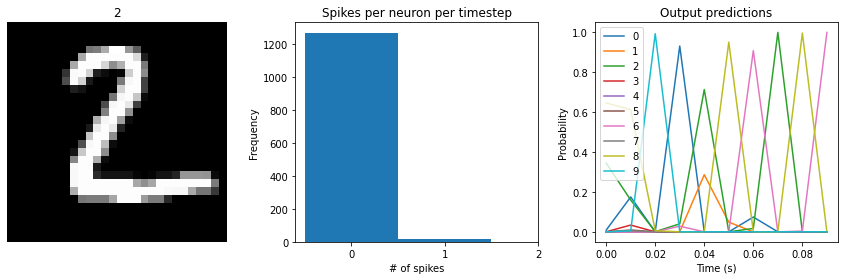

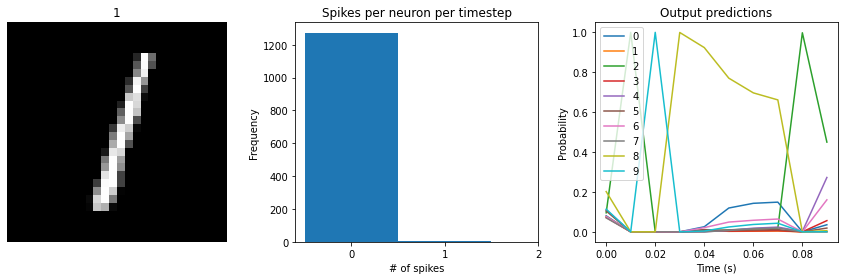

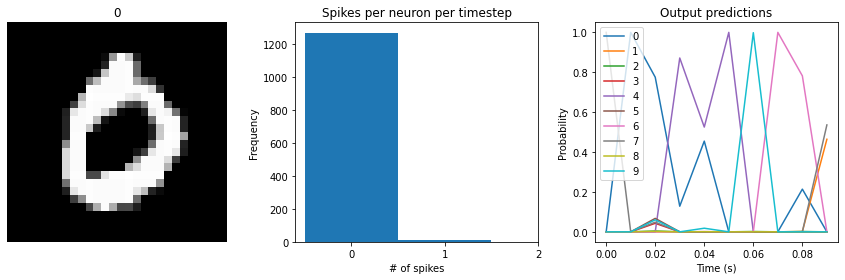

In [21]:
tau = 0.5
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

In [ ]:
tau = 1
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 1
Epoch 1/10
1875/1875 [==============================] - 51s 26ms/step - loss: 0.7218 - accuracy: 0.8308
Epoch 2/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1994 - accuracy: 0.9430
Epoch 3/10
1203/1875 [==================>...........] - ETA: 19s - loss: 0.1471 - accuracy: 0.9552- ETA: 21s 

In [23]:
print(tau_acc_dict)

{0.005: 25.41, 0.01: 25.86, 0.05: 26.38, 0.1: 27.389999999999997, 0.5: 26.66, 1: 26.400000000000002}
